In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch
warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 62

 ****************** Training and validation sets have been prepared **************** 

 prepare_single_data 
 prepare_semisingle_data 
 prepare_mix_data


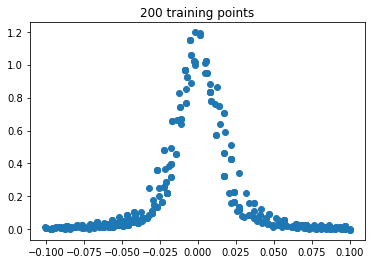

In [312]:
mode = 'Mixture'
%run EELS-ZLP.py

### Find uncertainties on data

44486


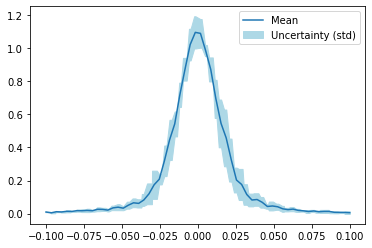

In [313]:
%run Functions.ipynb

nbins = 60

if mode == 'Mixture':
    x_train, y_train, x_val, y_val = prepare_mix_data()
if mode == 'Single':
    x_train, y_train = prepare_single_data()

# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector_t]

# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val, variance_vector_v]

## Neural Network 

### Create architecture

In [314]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(x, 5, activation=tf.nn.relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.relu)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    #hidden_layer_3 = tf.nn.dropout(hidden_layer_3, rate)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output

### Prepare data for training

In [315]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train)
print(N_train)
N_test = len(df_val)

predictions = make_model(x, 1)

cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta).minimize(cost)

train_x = np.array((df_train[:,0])).reshape(N_train,1)
train_y = np.array(df_train[:,1]).reshape(N_train,1)
train_sigma = np.array(df_train[:,2]).reshape(N_train,1)

test_x = np.array((df_train[:N_test,0])).reshape(N_test,1)
test_y = np.array(df_train[:N_test,1]).reshape(N_test,1)
test_sigma = np.array(df_train[:N_test,2]).reshape(N_test,1)



44486


### Train and validate

In [316]:
training_epochs = 10000
max_rising_epochs = 2000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 200
prev_test_cost = np.inf
prev_epoch=0
avg_cost = 0.0

array_train = []
array_test = []
print("Start training on", '%04d' %(N_train), "samples)")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x, 
                            y: train_y, 
                            sigma: train_sigma
                        })
        
        avg_cost = c 
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
        
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Train cost=", "{:.9f}".format(avg_cost), "| Test cost=", "{:.9f}".format(test_cost))
            array_train.append(avg_cost)
            array_test.append(test_cost)
                         
        if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The minimization stopped...","red"))
            print("Epoch:", '%04d' % (epoch+1), "| Best Train cost=", "{:.9f}".format(avg_cost), "| Test cost=", "{:.9f}".format(test_cost))
            print("Overfitting regime was about to start at epoch: ",epoch)
            break
            
        elif test_cost < prev_test_cost:
            
            prev_test_cost = test_cost
            prev_epoch = epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: train_x, 
                            y: train_y
                        })
    
    writer = tf.summary.FileWriter('./fetchesAndFeed',sess.graph)
    writer.close()

Start training on 44486 samples)
Epoch: 0001 | Train cost= 32.901111603 | Test cost= 2.981279373
Epoch: 0201 | Train cost= 23.075176239 | Test cost= 1.957606196
Epoch: 0401 | Train cost= 14.990349770 | Test cost= 1.405277610
Epoch: 0601 | Train cost= 7.427248001 | Test cost= 1.562897444
Epoch: 0801 | Train cost= 2.965698481 | Test cost= 1.472306728
Epoch: 1001 | Train cost= 1.787013054 | Test cost= 1.447257519
Epoch: 1201 | Train cost= 1.430047154 | Test cost= 1.449283957
Epoch: 1401 | Train cost= 1.281519294 | Test cost= 1.442090750
Epoch: 1601 | Train cost= 1.226675749 | Test cost= 1.441017151
Epoch: 1801 | Train cost= 1.205463290 | Test cost= 1.440596819
Epoch: 2001 | Train cost= 1.196330428 | Test cost= 1.448947072
Epoch: 2201 | Train cost= 1.185835838 | Test cost= 1.440654159

 The minimization stopped...
Epoch: 2386 | Best Train cost= 1.181130409 | Test cost= 1.440731168
Overfitting regime was about to start at epoch:  2385
Optimization Finished!


### Plot outputs

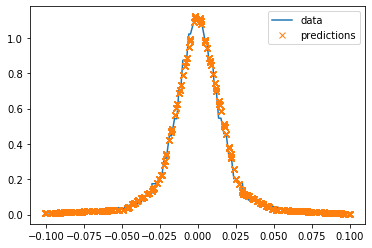

In [317]:
plt.plot(df_train[:,0], mean_vector_t, label='data')
plt.plot(train_x, predictions_values, 'x', label='predictions')
plt.legend()
plt.show()

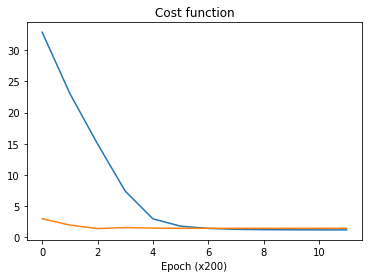

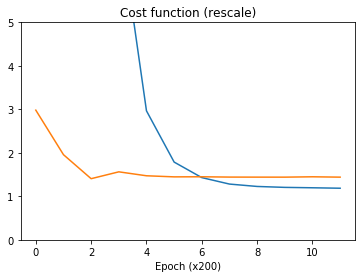

In [324]:
plt.plot(array_train, label='train')
plt.plot(array_test, label='test')
plt.title('Cost function')
plt.xlabel('Epoch (x200)')
plt.show()

plt.plot(array_train, label='train')
plt.plot(array_test, label='test')
plt.title('Cost function (rescale)')
plt.xlabel('Epoch (x200)')
plt.ylim([0,5])
plt.show()

